# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

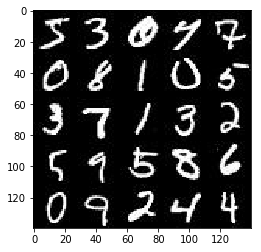

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

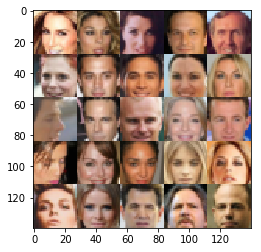

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/hiuchan/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    _input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    _z_data = tf.placeholder(tf.float32, [None, z_dim])
    _learning_rate = tf.placeholder(tf.float32)
    return _input, _z_data, _learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [19]:
def LeakyRelu(x):
    alpha = 0.2
    return tf.maximum(alpha * x, x)

In [28]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):

        dropout = 0.7
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x1 = tf.layers.dropout(x1, dropout)
        relu1 = LeakyRelu(x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.layers.dropout(x2, dropout)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = LeakyRelu(bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.dropout(x3, dropout)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = LeakyRelu(bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [30]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        dropout = 0.7
        x1 = tf.layers.dense(z, 2*2*512, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.dropout(x1, dropout)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = LeakyRelu(x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.layers.dropout(x2, dropout)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = LeakyRelu(x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.dropout(x3, dropout)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = LeakyRelu(x3)

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28 x 28 x out_channel_dim now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [31]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    smooth_factor = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*(1.0-smooth_factor)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [32]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [33]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [34]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(e+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.6606... Generator Loss: 0.0193
Epoch 1/2... Discriminator Loss: 1.6122... Generator Loss: 14.9639
Epoch 1/2... Discriminator Loss: 1.9232... Generator Loss: 9.4522
Epoch 1/2... Discriminator Loss: 1.8885... Generator Loss: 0.5345
Epoch 1/2... Discriminator Loss: 0.6402... Generator Loss: 1.8655
Epoch 1/2... Discriminator Loss: 0.7332... Generator Loss: 3.0302
Epoch 1/2... Discriminator Loss: 0.6337... Generator Loss: 2.3394
Epoch 1/2... Discriminator Loss: 0.5491... Generator Loss: 2.4067
Epoch 1/2... Discriminator Loss: 0.5306... Generator Loss: 2.8177
Epoch 1/2... Discriminator Loss: 0.6144... Generator Loss: 2.9787


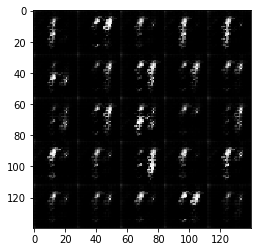

Epoch 1/2... Discriminator Loss: 1.5027... Generator Loss: 9.7595
Epoch 1/2... Discriminator Loss: 5.2693... Generator Loss: 14.7093
Epoch 1/2... Discriminator Loss: 0.6070... Generator Loss: 2.8364
Epoch 1/2... Discriminator Loss: 0.4608... Generator Loss: 2.9910
Epoch 1/2... Discriminator Loss: 0.4174... Generator Loss: 3.6075
Epoch 1/2... Discriminator Loss: 0.4102... Generator Loss: 3.1205
Epoch 1/2... Discriminator Loss: 0.4121... Generator Loss: 5.4841
Epoch 1/2... Discriminator Loss: 3.7790... Generator Loss: 11.8120
Epoch 1/2... Discriminator Loss: 0.5847... Generator Loss: 2.1361
Epoch 1/2... Discriminator Loss: 0.4358... Generator Loss: 3.1666


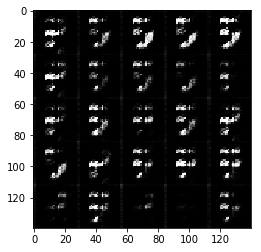

Epoch 1/2... Discriminator Loss: 0.5114... Generator Loss: 2.3712
Epoch 1/2... Discriminator Loss: 0.5131... Generator Loss: 2.7579
Epoch 1/2... Discriminator Loss: 0.5855... Generator Loss: 2.4469
Epoch 1/2... Discriminator Loss: 0.4994... Generator Loss: 3.0731
Epoch 1/2... Discriminator Loss: 0.4922... Generator Loss: 4.2876
Epoch 1/2... Discriminator Loss: 0.7088... Generator Loss: 1.6351
Epoch 1/2... Discriminator Loss: 0.5009... Generator Loss: 2.7010
Epoch 1/2... Discriminator Loss: 2.1435... Generator Loss: 8.1620
Epoch 1/2... Discriminator Loss: 1.4835... Generator Loss: 0.5059
Epoch 1/2... Discriminator Loss: 0.6305... Generator Loss: 1.8088


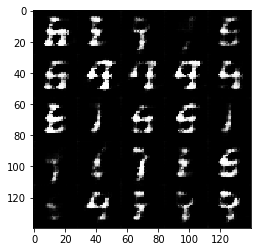

Epoch 1/2... Discriminator Loss: 0.5320... Generator Loss: 3.0309
Epoch 1/2... Discriminator Loss: 0.6113... Generator Loss: 3.0948
Epoch 1/2... Discriminator Loss: 0.7703... Generator Loss: 1.7058
Epoch 1/2... Discriminator Loss: 0.6213... Generator Loss: 3.0853
Epoch 1/2... Discriminator Loss: 0.9872... Generator Loss: 1.2048
Epoch 1/2... Discriminator Loss: 0.7361... Generator Loss: 1.9543
Epoch 1/2... Discriminator Loss: 0.9214... Generator Loss: 1.1948
Epoch 1/2... Discriminator Loss: 0.7917... Generator Loss: 3.7513
Epoch 1/2... Discriminator Loss: 1.2302... Generator Loss: 1.0158
Epoch 1/2... Discriminator Loss: 0.9180... Generator Loss: 1.2315


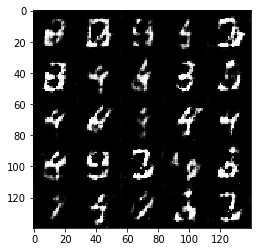

Epoch 1/2... Discriminator Loss: 0.8374... Generator Loss: 1.1943
Epoch 1/2... Discriminator Loss: 0.6348... Generator Loss: 2.0302
Epoch 1/2... Discriminator Loss: 0.8832... Generator Loss: 1.4991
Epoch 1/2... Discriminator Loss: 0.7844... Generator Loss: 1.5507
Epoch 1/2... Discriminator Loss: 0.6547... Generator Loss: 2.3695
Epoch 1/2... Discriminator Loss: 0.7943... Generator Loss: 1.4427
Epoch 1/2... Discriminator Loss: 0.9913... Generator Loss: 1.0857
Epoch 1/2... Discriminator Loss: 0.6562... Generator Loss: 2.2021
Epoch 1/2... Discriminator Loss: 0.9676... Generator Loss: 2.4739
Epoch 1/2... Discriminator Loss: 0.6473... Generator Loss: 2.2853


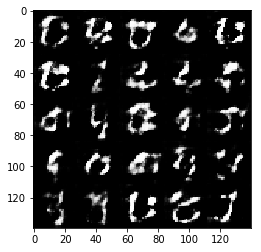

Epoch 1/2... Discriminator Loss: 2.0436... Generator Loss: 4.5841
Epoch 1/2... Discriminator Loss: 0.7534... Generator Loss: 1.6889
Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 1.7642
Epoch 1/2... Discriminator Loss: 1.0091... Generator Loss: 1.2396
Epoch 1/2... Discriminator Loss: 0.8966... Generator Loss: 2.5747
Epoch 1/2... Discriminator Loss: 1.1148... Generator Loss: 0.8761
Epoch 1/2... Discriminator Loss: 1.3169... Generator Loss: 0.7354
Epoch 1/2... Discriminator Loss: 0.8589... Generator Loss: 1.5196
Epoch 1/2... Discriminator Loss: 0.8432... Generator Loss: 1.6687
Epoch 1/2... Discriminator Loss: 1.0519... Generator Loss: 2.4246


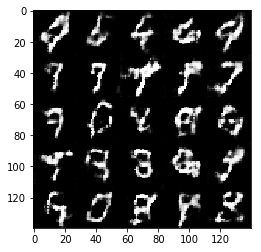

Epoch 1/2... Discriminator Loss: 0.7987... Generator Loss: 1.3958
Epoch 1/2... Discriminator Loss: 0.8707... Generator Loss: 1.3961
Epoch 1/2... Discriminator Loss: 0.9186... Generator Loss: 1.0874
Epoch 1/2... Discriminator Loss: 0.7770... Generator Loss: 1.4381
Epoch 1/2... Discriminator Loss: 0.8139... Generator Loss: 1.8753
Epoch 1/2... Discriminator Loss: 1.0031... Generator Loss: 1.0819
Epoch 1/2... Discriminator Loss: 0.8618... Generator Loss: 1.4728
Epoch 1/2... Discriminator Loss: 1.1106... Generator Loss: 0.8099
Epoch 1/2... Discriminator Loss: 0.8614... Generator Loss: 1.4045
Epoch 1/2... Discriminator Loss: 0.8492... Generator Loss: 1.3496


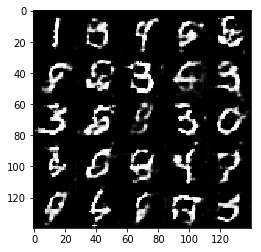

Epoch 1/2... Discriminator Loss: 1.0799... Generator Loss: 1.0087
Epoch 1/2... Discriminator Loss: 1.2102... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 0.9811... Generator Loss: 1.0535
Epoch 1/2... Discriminator Loss: 0.8546... Generator Loss: 1.6842
Epoch 1/2... Discriminator Loss: 1.0770... Generator Loss: 0.8858
Epoch 1/2... Discriminator Loss: 0.7851... Generator Loss: 1.4909
Epoch 1/2... Discriminator Loss: 0.7876... Generator Loss: 1.5700
Epoch 1/2... Discriminator Loss: 1.0663... Generator Loss: 1.0440
Epoch 1/2... Discriminator Loss: 1.0097... Generator Loss: 1.0594
Epoch 1/2... Discriminator Loss: 1.0116... Generator Loss: 1.0973


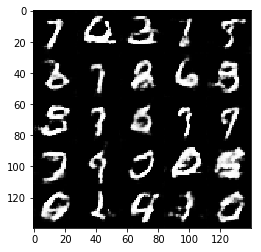

Epoch 1/2... Discriminator Loss: 0.7867... Generator Loss: 1.4921
Epoch 1/2... Discriminator Loss: 1.1928... Generator Loss: 0.8015
Epoch 1/2... Discriminator Loss: 1.0848... Generator Loss: 2.8246
Epoch 1/2... Discriminator Loss: 0.8196... Generator Loss: 2.5448
Epoch 1/2... Discriminator Loss: 0.7524... Generator Loss: 1.8029
Epoch 1/2... Discriminator Loss: 1.5375... Generator Loss: 0.8202
Epoch 1/2... Discriminator Loss: 1.0240... Generator Loss: 1.9278
Epoch 1/2... Discriminator Loss: 0.9184... Generator Loss: 1.6971
Epoch 1/2... Discriminator Loss: 0.9153... Generator Loss: 1.3759
Epoch 1/2... Discriminator Loss: 0.9032... Generator Loss: 1.7061


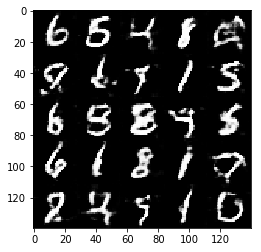

Epoch 1/2... Discriminator Loss: 1.0052... Generator Loss: 0.9026
Epoch 1/2... Discriminator Loss: 0.9672... Generator Loss: 1.0631
Epoch 1/2... Discriminator Loss: 0.9613... Generator Loss: 1.0349
Epoch 2/2... Discriminator Loss: 1.1283... Generator Loss: 0.7929
Epoch 2/2... Discriminator Loss: 1.1513... Generator Loss: 2.9245
Epoch 2/2... Discriminator Loss: 0.9969... Generator Loss: 0.9715
Epoch 2/2... Discriminator Loss: 0.9508... Generator Loss: 1.0589
Epoch 2/2... Discriminator Loss: 1.0011... Generator Loss: 1.4798
Epoch 2/2... Discriminator Loss: 0.9133... Generator Loss: 1.6683
Epoch 2/2... Discriminator Loss: 1.0164... Generator Loss: 1.1701


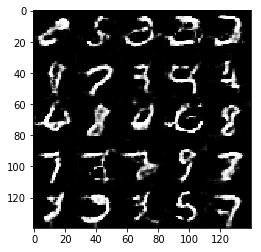

Epoch 2/2... Discriminator Loss: 0.9198... Generator Loss: 1.5318
Epoch 2/2... Discriminator Loss: 0.8537... Generator Loss: 1.8084
Epoch 2/2... Discriminator Loss: 1.0351... Generator Loss: 0.8716
Epoch 2/2... Discriminator Loss: 0.9769... Generator Loss: 0.9870
Epoch 2/2... Discriminator Loss: 0.9133... Generator Loss: 1.1659
Epoch 2/2... Discriminator Loss: 0.9904... Generator Loss: 0.9168
Epoch 2/2... Discriminator Loss: 1.3442... Generator Loss: 0.5608
Epoch 2/2... Discriminator Loss: 1.5339... Generator Loss: 0.4514
Epoch 2/2... Discriminator Loss: 0.8668... Generator Loss: 1.1221
Epoch 2/2... Discriminator Loss: 0.9206... Generator Loss: 1.0507


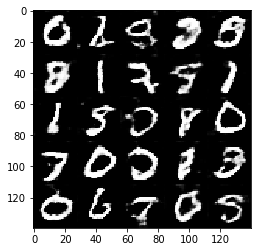

Epoch 2/2... Discriminator Loss: 0.8646... Generator Loss: 1.4581
Epoch 2/2... Discriminator Loss: 0.7641... Generator Loss: 1.4050
Epoch 2/2... Discriminator Loss: 1.1857... Generator Loss: 0.7044
Epoch 2/2... Discriminator Loss: 0.8721... Generator Loss: 2.2082
Epoch 2/2... Discriminator Loss: 0.8650... Generator Loss: 1.8272
Epoch 2/2... Discriminator Loss: 0.8624... Generator Loss: 1.4280
Epoch 2/2... Discriminator Loss: 0.7889... Generator Loss: 1.4809
Epoch 2/2... Discriminator Loss: 1.2590... Generator Loss: 0.6149
Epoch 2/2... Discriminator Loss: 1.3285... Generator Loss: 0.7197
Epoch 2/2... Discriminator Loss: 0.9610... Generator Loss: 1.0374


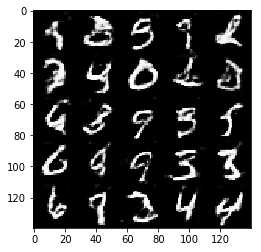

Epoch 2/2... Discriminator Loss: 2.5474... Generator Loss: 0.1646
Epoch 2/2... Discriminator Loss: 1.0545... Generator Loss: 1.6068
Epoch 2/2... Discriminator Loss: 1.0074... Generator Loss: 1.0052
Epoch 2/2... Discriminator Loss: 1.0883... Generator Loss: 1.0919
Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 1.2425
Epoch 2/2... Discriminator Loss: 0.9343... Generator Loss: 1.4789
Epoch 2/2... Discriminator Loss: 1.4769... Generator Loss: 0.4928
Epoch 2/2... Discriminator Loss: 1.1363... Generator Loss: 0.7814
Epoch 2/2... Discriminator Loss: 1.0566... Generator Loss: 0.8869
Epoch 2/2... Discriminator Loss: 0.9476... Generator Loss: 1.9969


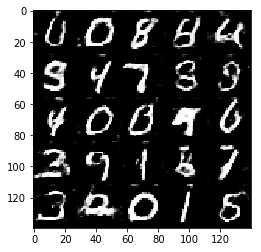

Epoch 2/2... Discriminator Loss: 0.9757... Generator Loss: 1.2268
Epoch 2/2... Discriminator Loss: 1.5011... Generator Loss: 1.3175
Epoch 2/2... Discriminator Loss: 0.8072... Generator Loss: 1.3357
Epoch 2/2... Discriminator Loss: 2.3047... Generator Loss: 3.8053
Epoch 2/2... Discriminator Loss: 1.1097... Generator Loss: 1.0278
Epoch 2/2... Discriminator Loss: 1.0823... Generator Loss: 0.8183
Epoch 2/2... Discriminator Loss: 1.3327... Generator Loss: 0.6761
Epoch 2/2... Discriminator Loss: 0.8717... Generator Loss: 1.4627
Epoch 2/2... Discriminator Loss: 0.9362... Generator Loss: 1.2161
Epoch 2/2... Discriminator Loss: 2.6870... Generator Loss: 3.7120


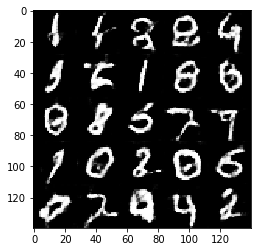

Epoch 2/2... Discriminator Loss: 1.0692... Generator Loss: 0.8253
Epoch 2/2... Discriminator Loss: 0.9241... Generator Loss: 1.6077
Epoch 2/2... Discriminator Loss: 1.1555... Generator Loss: 0.7107
Epoch 2/2... Discriminator Loss: 1.0076... Generator Loss: 0.8620
Epoch 2/2... Discriminator Loss: 0.7830... Generator Loss: 1.4092
Epoch 2/2... Discriminator Loss: 1.1582... Generator Loss: 2.2744
Epoch 2/2... Discriminator Loss: 0.8927... Generator Loss: 1.1498
Epoch 2/2... Discriminator Loss: 1.1811... Generator Loss: 0.6995
Epoch 2/2... Discriminator Loss: 0.7496... Generator Loss: 1.3826
Epoch 2/2... Discriminator Loss: 1.0412... Generator Loss: 0.9651


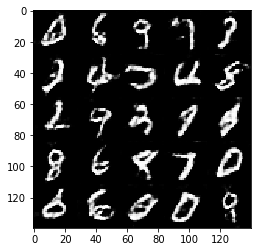

Epoch 2/2... Discriminator Loss: 1.2193... Generator Loss: 0.6563
Epoch 2/2... Discriminator Loss: 1.0582... Generator Loss: 0.8552
Epoch 2/2... Discriminator Loss: 0.6984... Generator Loss: 1.5885
Epoch 2/2... Discriminator Loss: 0.8670... Generator Loss: 1.2390
Epoch 2/2... Discriminator Loss: 0.8741... Generator Loss: 1.4479
Epoch 2/2... Discriminator Loss: 0.9233... Generator Loss: 1.2246
Epoch 2/2... Discriminator Loss: 1.0458... Generator Loss: 0.9514
Epoch 2/2... Discriminator Loss: 1.0271... Generator Loss: 0.8864
Epoch 2/2... Discriminator Loss: 1.2830... Generator Loss: 0.5944
Epoch 2/2... Discriminator Loss: 1.0328... Generator Loss: 0.9343


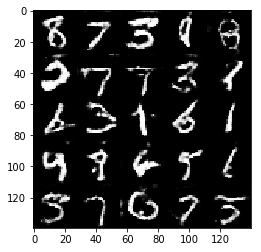

Epoch 2/2... Discriminator Loss: 1.2993... Generator Loss: 0.7071
Epoch 2/2... Discriminator Loss: 1.1732... Generator Loss: 1.6898
Epoch 2/2... Discriminator Loss: 1.1018... Generator Loss: 2.2501
Epoch 2/2... Discriminator Loss: 1.0385... Generator Loss: 1.8368
Epoch 2/2... Discriminator Loss: 0.8971... Generator Loss: 1.7916
Epoch 2/2... Discriminator Loss: 1.1110... Generator Loss: 0.8300
Epoch 2/2... Discriminator Loss: 0.7278... Generator Loss: 1.7178
Epoch 2/2... Discriminator Loss: 0.9078... Generator Loss: 1.7916
Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.5472
Epoch 2/2... Discriminator Loss: 1.4450... Generator Loss: 0.4997


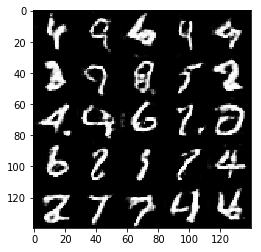

Epoch 2/2... Discriminator Loss: 1.0051... Generator Loss: 0.9569
Epoch 2/2... Discriminator Loss: 1.0933... Generator Loss: 0.7535
Epoch 2/2... Discriminator Loss: 1.3248... Generator Loss: 0.6626
Epoch 2/2... Discriminator Loss: 0.9971... Generator Loss: 1.7419
Epoch 2/2... Discriminator Loss: 0.8713... Generator Loss: 1.5530
Epoch 2/2... Discriminator Loss: 0.7745... Generator Loss: 1.2276
Epoch 2/2... Discriminator Loss: 0.8435... Generator Loss: 1.3344
Epoch 2/2... Discriminator Loss: 1.1608... Generator Loss: 0.8349
Epoch 2/2... Discriminator Loss: 0.8554... Generator Loss: 1.1432
Epoch 2/2... Discriminator Loss: 1.3433... Generator Loss: 1.8666


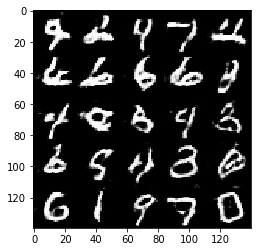

Epoch 2/2... Discriminator Loss: 1.1187... Generator Loss: 0.9301
Epoch 2/2... Discriminator Loss: 1.2043... Generator Loss: 0.7093
Epoch 2/2... Discriminator Loss: 1.1565... Generator Loss: 0.7191
Epoch 2/2... Discriminator Loss: 1.0417... Generator Loss: 1.0061
Epoch 2/2... Discriminator Loss: 1.0223... Generator Loss: 2.1278
Epoch 2/2... Discriminator Loss: 1.0300... Generator Loss: 0.9928
Epoch 2/2... Discriminator Loss: 0.9126... Generator Loss: 1.1058


In [35]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 13.2433
Epoch 1/1... Discriminator Loss: 1.7789... Generator Loss: 0.3629
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 11.1262
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 11.5032
Epoch 1/1... Discriminator Loss: 0.5955... Generator Loss: 2.3808
Epoch 1/1... Discriminator Loss: 2.5638... Generator Loss: 0.1472
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 3.1538
Epoch 1/1... Discriminator Loss: 0.7032... Generator Loss: 1.9375
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 4.0047
Epoch 1/1... Discriminator Loss: 0.9747... Generator Loss: 1.3692


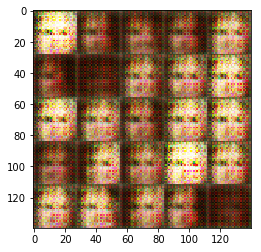

Epoch 1/1... Discriminator Loss: 0.6510... Generator Loss: 1.5145
Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 3.4050
Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 2.8506
Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 1.4669
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 2.0654
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 2.1842
Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 1.0309
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 3.3842
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 2.9175
Epoch 1/1... Discriminator Loss: 1.6635... Generator Loss: 0.9312


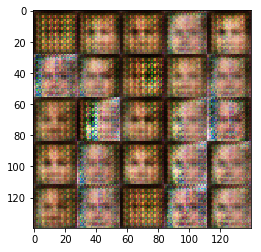

Epoch 1/1... Discriminator Loss: 1.9325... Generator Loss: 0.3932
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 1.9637
Epoch 1/1... Discriminator Loss: 1.7334... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 1.3783
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 1.6231... Generator Loss: 0.4321
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 1.8384


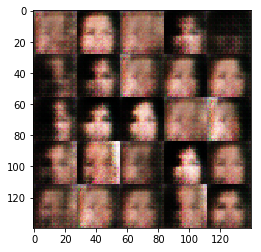

Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 1.2234
Epoch 1/1... Discriminator Loss: 0.8330... Generator Loss: 1.9187
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.9960
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 1.1811
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 1.7563
Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 1.5984
Epoch 1/1... Discriminator Loss: 1.8056... Generator Loss: 0.5150
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 1.1656


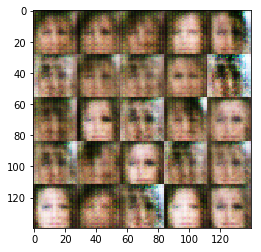

Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 1.5387
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 1.7198
Epoch 1/1... Discriminator Loss: 2.0786... Generator Loss: 0.3793
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 1.2484
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 1.2254
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 2.3054
Epoch 1/1... Discriminator Loss: 1.8805... Generator Loss: 2.5585


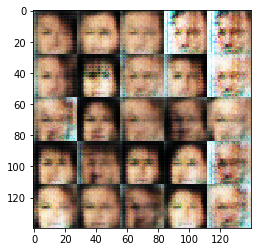

Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.6616... Generator Loss: 3.2022
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 1.2398
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 1.3964
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.0986
Epoch 1/1... Discriminator Loss: 1.5942... Generator Loss: 4.0258
Epoch 1/1... Discriminator Loss: 0.8194... Generator Loss: 1.2697
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.8184


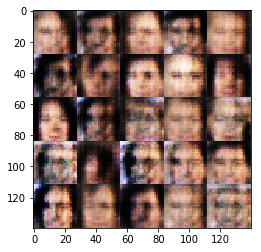

Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.5555
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 1.4978
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 2.1565
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.4459
Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 1.0512


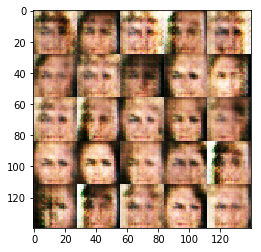

Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.4388
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.6122
Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 1.4988
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 1.1561
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 1.1352
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 1.2507
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.2159
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 1.3083
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 1.9885


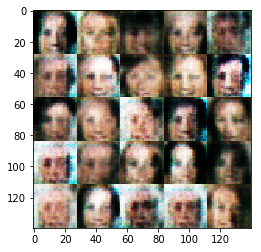

Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.4472
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.5390
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.8896
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.8137... Generator Loss: 0.3539


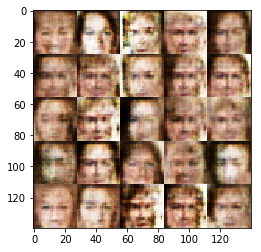

Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 2.5747
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 1.6920
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 1.1494
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 1.8392
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 1.5780
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 1.5691
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 1.2134


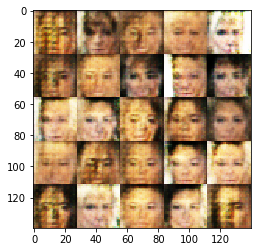

Epoch 1/1... Discriminator Loss: 0.7479... Generator Loss: 1.9011
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 1.9882
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 1.7863
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.5302
Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 1.0410
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.5106
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 1.2046


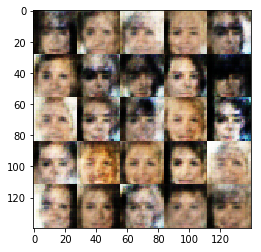

Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 1.3955
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 2.4035
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 1.2226
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 1.0682
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.4319
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 1.3772
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 1.1815
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 1.0410


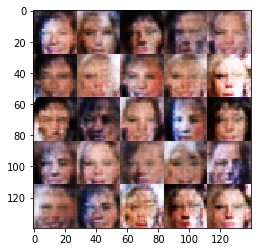

Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 1.8806
Epoch 1/1... Discriminator Loss: 0.7866... Generator Loss: 1.5001
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.8596
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 1.8427
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 1.9481
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 1.0824
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 1.5872
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 2.0511
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 1.1874
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 1.1032


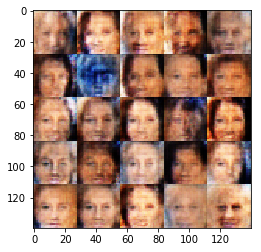

Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 1.1857
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 1.2215
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 1.0658
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 1.1117
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.6838


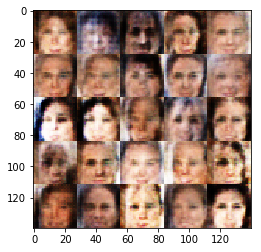

Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 1.2889
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 1.5186
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.3609
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 1.5994
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 1.2745


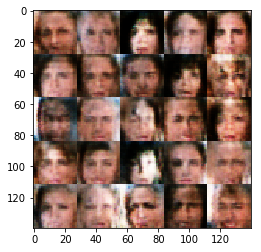

Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 1.2380
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 1.5613
Epoch 1/1... Discriminator Loss: 1.6360... Generator Loss: 0.4337
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.6207


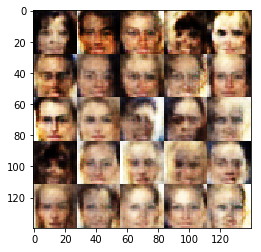

Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 1.3227
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 1.7250
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 1.4175
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 1.5193
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 1.4847
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.9603


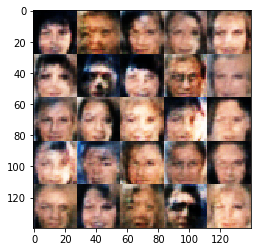

Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 1.2889
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 1.1457
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 1.3682
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.2590
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 1.3308
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 1.3525


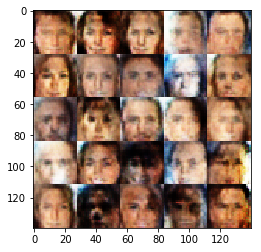

Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.2195
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.2838
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.5675
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 1.7133
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.4119
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 2.2555
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.7506


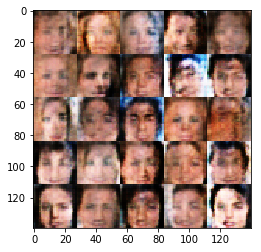

Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.4962
Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 1.3684
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 1.2983
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.5644
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 1.2423
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 0.9901


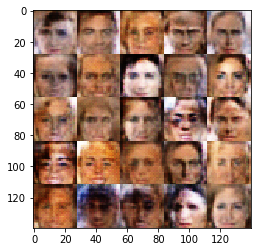

Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 1.3671
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 1.3316
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.1997
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 1.6659
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 1.5367
Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 1.3021
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.7256


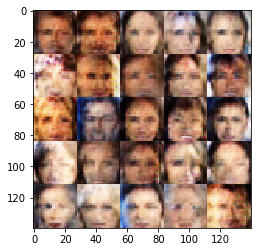

Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 0.9986
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.3573
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 1.8362
Epoch 1/1... Discriminator Loss: 1.5692... Generator Loss: 0.4313
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 1.3756
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.9547
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 1.0856


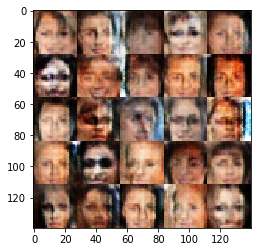

Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 1.1491
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 1.4595
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 1.0599
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 1.2048
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 1.1400
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 1.4614
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 1.0408


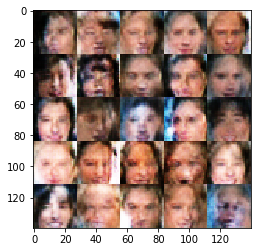

Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 1.7237
Epoch 1/1... Discriminator Loss: 0.9923... Generator Loss: 1.3280
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 1.0531
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 1.0350
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 1.4893


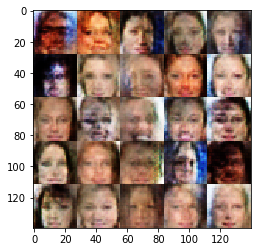

Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 1.5410
Epoch 1/1... Discriminator Loss: 1.7963... Generator Loss: 0.3055
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 1.1664
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 1.2736
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.7263


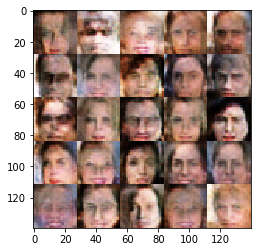

Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 1.2455
Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 0.8818... Generator Loss: 2.0580
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 1.3869
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 1.2248
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.2311
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.9953
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 1.1068


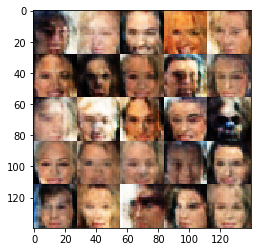

Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 1.2353
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.1717
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 1.2777
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 1.2420
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 1.1200


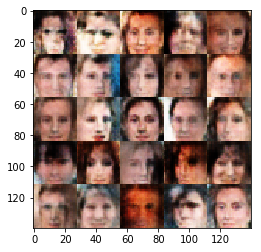

Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.0898
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.4042
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.8240... Generator Loss: 0.3155
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 1.0440


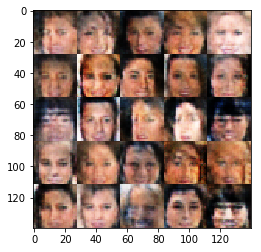

Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 1.6867
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 1.4699
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 1.2587
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 1.2502
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.8899


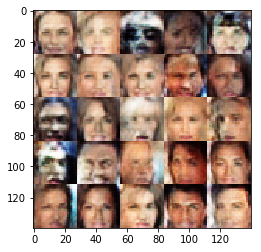

Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 1.6781
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 1.4472
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.3720
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 1.1672
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.8830


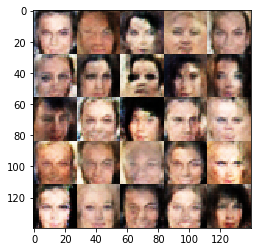

Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.4700
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 1.6778
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.6647


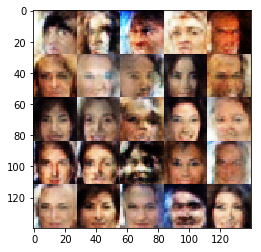

Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 1.2242
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 1.3130
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 1.0957
Epoch 1/1... Discriminator Loss: 0.8821... Generator Loss: 1.4681
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 1.4335
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 1.1334
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.6652... Generator Loss: 0.3665


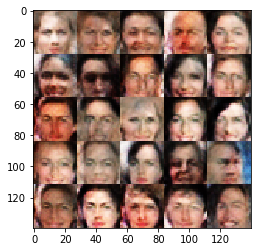

Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 1.6729
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 1.1218
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 1.3004
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 1.1209
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 1.0487
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 1.0595


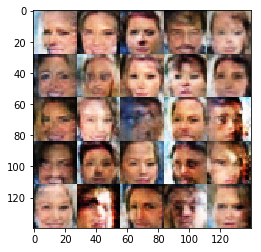

Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 1.0468
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 1.1832
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 1.5526
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 1.1589
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 0.9915


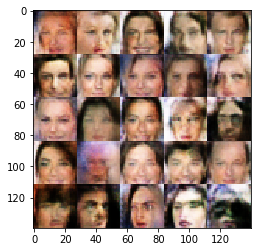

Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 1.1592
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 1.3534
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 1.0761
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.7009


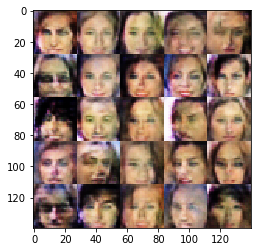

Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 1.8333
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 1.1544
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 1.1319
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.9470
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.5668
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 1.2064
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 1.0438
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 1.2756
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 1.9083
Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 1.5599


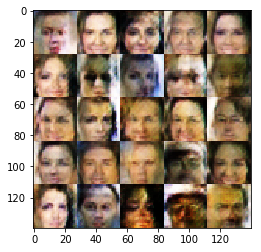

Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.4629
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 1.0852
Epoch 1/1... Discriminator Loss: 1.5826... Generator Loss: 0.3980
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 1.6175


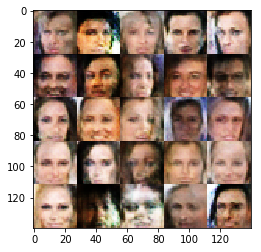

Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 1.1253
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 1.3443
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 1.3063


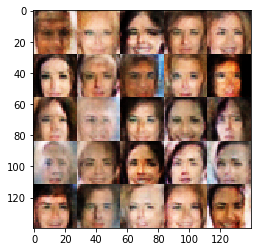

Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.4459
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.3281
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 1.4188


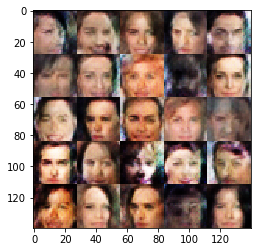

Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 1.1564
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 1.5116
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 1.8726
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.7524


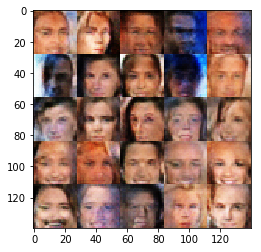

Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.4002
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 1.0622
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.6594... Generator Loss: 0.3734
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.7980


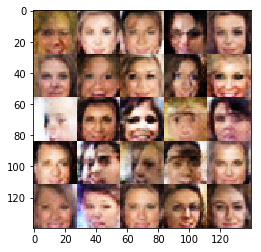

Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 1.6320
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 1.2643
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 1.0377
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 1.3612
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.8745


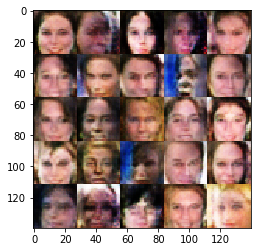

Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 1.2972
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.6133


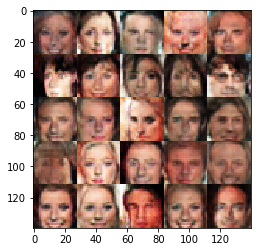

Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 1.0166
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.5612


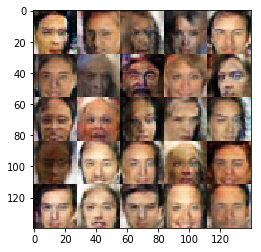

Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 1.7298
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 1.1587
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 1.0369
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.6834


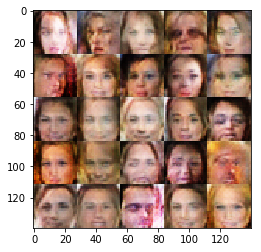

Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.1296
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 1.4254
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 1.3867
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 1.1780
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 1.2081
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 1.1183
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.3785


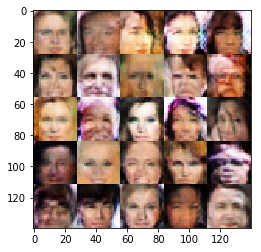

Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 1.3686
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 1.1623
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 1.2697
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 1.5236
Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 1.1362
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 1.3008


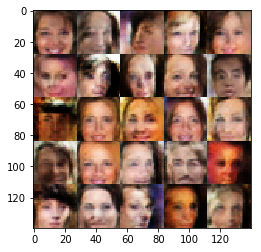

Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.9570
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.1054
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 0.9425... Generator Loss: 1.3213
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 1.3430
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 1.0286


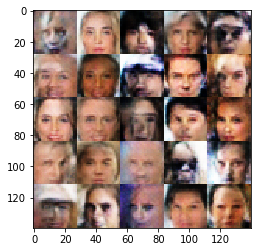

Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 1.5250
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 1.1048
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.4620
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 0.9193


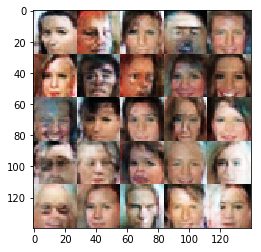

Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.2161
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 1.1166


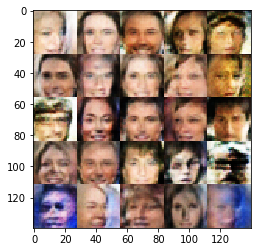

Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 1.2098
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 1.3493
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 1.2751
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 1.1322


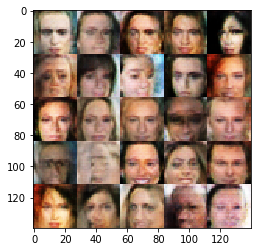

Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.4828
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 1.2225
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 1.0356


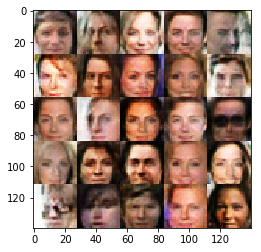

Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.3559
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.4887
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 1.3972
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 1.1421


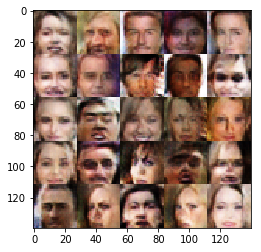

Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 1.4178
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 1.4659
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 0.9770


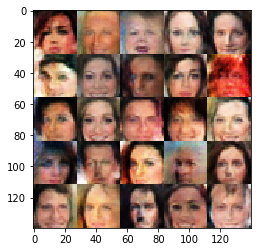

Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 1.1702
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 1.5807... Generator Loss: 0.4341
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.9679


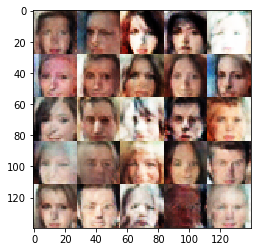

Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.5295... Generator Loss: 0.4502
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 1.5396
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 1.1274
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 0.9577


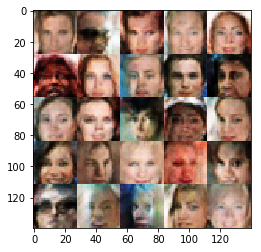

Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.4755
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.5319
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.0311
Epoch 1/1... Discriminator Loss: 1.7196... Generator Loss: 1.4055
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 0.9435


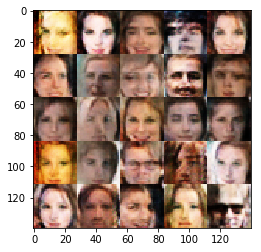

Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.6652... Generator Loss: 0.4048
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 1.0439
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 1.3287


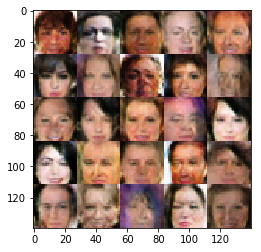

Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.9642
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 1.1622
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 1.3185
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.9779


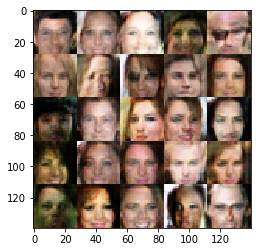

Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.5045
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.8465


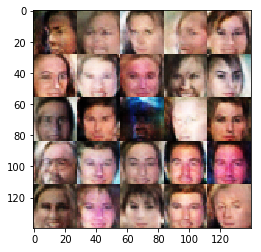

Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 1.2969
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 1.0028
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.7872


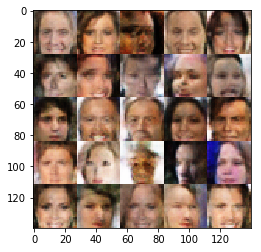

Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 1.1376
Epoch 1/1... Discriminator Loss: 0.9686... Generator Loss: 1.5995
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.5061
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 1.4402
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.6905


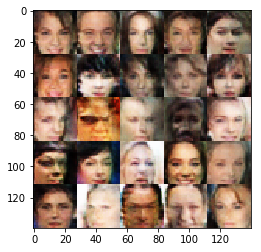

Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 1.1534
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 1.6982
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.6733


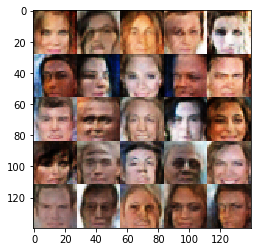

Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.3773
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 0.9259


In [36]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.